# Frequentist Inference Case Study - Part B

## Learning objectives

Welcome to Part B of the Frequentist inference case study! The purpose of this case study is to help you apply the concepts associated with Frequentist inference in Python. In particular, you'll practice writing Python code to apply the following statistical concepts: 
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, including its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate a confidence interval

In the previous notebook, we used only data from a known normal distribution. **You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.**

## Hospital medical charges

Imagine that a hospital has hired you as their data scientist. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. 

In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?

Answering that last question with a frequentist approach makes some assumptions, and requires some knowledge, about the two groups.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). 

For the purposes of this exercise, assume the observations are the result of random sampling from our single hospital. Recall that in the previous assignment, we introduced the Central Limit Theorem (CLT), and its consequence that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data! Recall, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from numpy.random import seed
medical = pd.read_csv('data/insurance2.csv')

In [22]:
medical.shape

(1338, 8)

In [23]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q1:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

Charge mean: 13270.422265141257
Charge std: 12105.484975561612


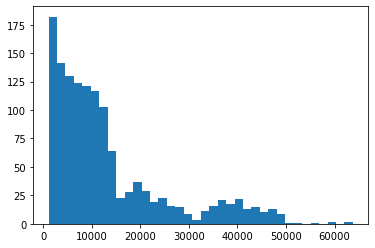

In [24]:
plt.hist(medical.charges, bins=int(np.sqrt(len(medical.charges))))
charge_mean = np.mean(medical.charges)
print(f"Charge mean: {charge_mean}")
charge_std = np.std(medical.charges)
print(f"Charge std: {charge_std}")

__A:__ The distribution of charges doesn't look anywhere near normal, which would be concerning if we had a small sample size. However, our sample size is large at 1,338, which places some confidence in the mean. The standard deviation, however, is not very helpful given it is nearly as large as the mean. 

__Q2:__ The administrator is concerned that the actual average charge has fallen below 12,000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

__A:__ Assuming this data represents a random sample of charges, I would take advantage of the CLT with bootstrapping the entire sample and resample with replacement many, many times to estimate the probability that the mean falls above 12,000. A quick glance at the mean of 13,270 and standard deviation of 331 shows that a 12,000 is less than three standard deviatations less than the mean. This suggests that the probability of the true mean falling above 12,000 is at least 99%. After a quick CDF check (below), the probability is more precisely greater than 99.99%.

Bootstrap mean: 13269.883811335161
Bootstrap std: 331.24330810126696


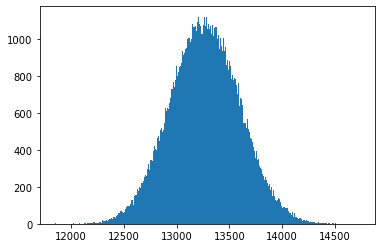

In [25]:
seed(47)
# take your samples here
samples = []
for i in range(100000):
    samples.append(np.mean(np.random.choice(medical.charges, len(medical.charges))))

plt.hist(samples, bins=int(np.sqrt(len(samples))))
print(f"Bootstrap mean: {np.mean(samples)}")
print(f"Bootstrap std: {np.std(samples, ddof=1)}")

__Q3:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A ***one-sided*** or ***two-sided*** interval? (Refresh your understanding of this concept on p. 399 of the *AoS*). Calculate the critical value and the relevant 95% confidence interval for the mean, and comment on whether the administrator should be concerned.

__A:__ Since the administrator's concern is limited to the mean falling only below a value, the appropriate confidence interval is one-sided (the probability that the mean falls either above or below 12,000). The 95% confidence interval is at 12,725, meaning the probability of the true mean falling above 12,725 (let alone 12,000) is 95%. In fact, the probability of the true mean being below 12,000 is <0.0001%. I don't think the administrator should be concerned.

In [26]:
from scipy.stats import norm

std_multiplier = norm.ppf(0.05)
print(f"Std multiplier: {std_multiplier}")
margin_of_error = std_multiplier * np.std(samples, ddof=1)
print(f"Margin of error: {margin_of_error}")
lower_conf_int = np.mean(samples) + margin_of_error
print(f"Lower Confidence Interval: {lower_conf_int}")

Std multiplier: -1.6448536269514729
Margin of error: -544.8467567337732
Lower Confidence Interval: 12725.037054601387


In [27]:
critical_z = (12000 - np.mean(samples))/np.std(samples, ddof=1)
print(f"Critical z: {critical_z}")
print(f"Probabiliy above 12,000: {1-norm.cdf(critical_z)}")
print(f"Probability below 12,000: {norm.cdf(critical_z)}")

Critical z: -3.8336889539423846
Probabiliy above 12,000: 0.9999368821253621
Probability below 12,000: 6.311787463789218e-05


The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q4:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means, where the pooled standard deviation of the two groups is given by:
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t*-test statistic is then given by:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

(If you need some reminding of the general definition of ***t-statistic***, check out the definition on p. 404 of *AoS*). 

What assumption about the variances of the two groups are we making here?

__A:__ The null hypothesis is those people with insurance are NOT charged a different amount than those without. The alternate hypothesis is those people with insurance are charged a different amount than those without. The assumption made for these groups is normal distribution.

In [28]:
medical_insurance = medical[medical.insuranceclaim == 1]
medical_no_insurance = medical[medical.insuranceclaim == 0]
print(f"Insurance shape: {medical_insurance.shape}")
print(f"No Insurance shape: {medical_no_insurance.shape}")

Insurance shape: (783, 8)
No Insurance shape: (555, 8)


__Q5:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

In [29]:
#manual approach
insurance_std = np.std(medical_insurance.charges)
no_insurance_std = np.std(medical_no_insurance.charges)

pooled_std = np.sqrt( ((( len(medical_insurance.charges) - 1) * (insurance_std**2)) + ((len(medical_no_insurance.charges) - 1) * (no_insurance_std**2)) ) / (len(medical_insurance.charges) + len(medical_no_insurance.charges) - 2) )
print(f"Pooled std: {pooled_std}")
t_stat = (np.mean(medical_insurance.charges) - np.mean(medical_no_insurance.charges))/(pooled_std * np.sqrt(1/len(medical_insurance.charges) + 1/len(medical_no_insurance.charges)))
print(f"t-test Statistic: {t_stat}")
p = (1 - t.cdf(abs(t_stat), len(medical_insurance.charges) + len(medical_no_insurance.charges) - 2)) * 2
print(f"p-value: {p}")

Pooled std: 11512.282899205748
t-test Statistic: 11.901306943555388
p-value: 0.0


In [30]:
#scipy.stats approach
from scipy.stats import ttest_ind
ttest_ind(medical_insurance.charges, medical_no_insurance.charges)

Ttest_indResult(statistic=11.893299030876712, pvalue=4.461230231620717e-31)

__A:__ The t-test statistic is off by <0.01 (rounding error?) and that scipy.stats p-value is essentially zero, so I'm calling this verified!

Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do is pass your data to it.

__Q6:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__ I believe this is asking for [scipy.stats.normaltest](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#scipy.stats.normaltest). It can also be found in the statsmodels package as [statsmodels.stats.weightstats.ztest](https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ztest.html). 

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test